In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import os
os.chdir('..')

# import the necessary packag
from adbench.datasets.data_generator import DataGenerator
from adbench.myutils import Utils

datagenerator = DataGenerator()
utils = Utils()

In [2]:
from adbench.baseline.PyOD import PYOD
from adbench.baseline.Supervised import supervised
from adbench.baseline.PReNet.run import PReNet
from adbench.baseline.GANomaly.run import GANomaly

# dataset and model list / dict
dataset_list = ['1_ALOI']
model_dict = {'GANomaly': GANomaly, 'XGBOD': PYOD, 'CatB': supervised, 'COPOD': PYOD, 'ECOD': PYOD, 'PReNet':PReNet}

# save the results
df_AUCROC = pd.DataFrame(data=None, index=dataset_list, columns = model_dict.keys())
df_AUCPR = pd.DataFrame(data=None, index=dataset_list, columns = model_dict.keys())

In [3]:
# save the results
df_results = pd.DataFrame(columns=['Model', 'AUCROC', 'AUCPR'])

# seed for reproducibility
seed = 42

for dataset in dataset_list:
    # Import the dataset
    datagenerator.dataset = dataset
    data = datagenerator.generator(la=0.1, realistic_synthetic_mode=None, noise_type=None)
    
    for name, clf in model_dict.items():
        clf = clf(seed=seed, model_name=name)
        clf = clf.fit(X_train=data['X_train'], y_train=data['y_train'])
        
        # Evaluation
        score = clf.predict_score(data['X_test'])
        result = utils.metric(y_true=data['y_test'], y_score=score)
        
        # Save results
        new_row = pd.DataFrame({
            'Model': [name],
            'AUCROC': [result['aucroc']],
            'AUCPR': [result['aucpr']]
        })
        df_results = pd.concat([df_results, new_row], ignore_index=True)
        df_AUCROC.loc[dataset, name] = result['aucroc']
        df_AUCPR.loc[dataset, name] = result['aucpr']


subsampling for dataset 1_ALOI...
current noise type: None
{'Samples': 10000, 'Features': 27, 'Anomalies': 302, 'Anomalies Ratio(%)': 3.02}
best param: None
Learning rate set to 0.023648
0:	learn: 0.6279188	total: 137ms	remaining: 2m 16s
1:	learn: 0.5683493	total: 144ms	remaining: 1m 11s
2:	learn: 0.5148908	total: 150ms	remaining: 49.9s
3:	learn: 0.4640346	total: 155ms	remaining: 38.6s
4:	learn: 0.4220544	total: 160ms	remaining: 31.8s
5:	learn: 0.3827438	total: 165ms	remaining: 27.3s
6:	learn: 0.3480773	total: 169ms	remaining: 24s
7:	learn: 0.3174367	total: 174ms	remaining: 21.6s
8:	learn: 0.2882729	total: 178ms	remaining: 19.6s
9:	learn: 0.2630682	total: 182ms	remaining: 18.1s
10:	learn: 0.2400025	total: 187ms	remaining: 16.8s
11:	learn: 0.2190697	total: 191ms	remaining: 15.8s
12:	learn: 0.2011648	total: 196ms	remaining: 14.9s
13:	learn: 0.1841713	total: 200ms	remaining: 14.1s
14:	learn: 0.1694869	total: 205ms	remaining: 13.4s
15:	learn: 0.1558192	total: 210ms	remaining: 12.9s
16:	lea

In [4]:
# Display the results
df_results = df_results.sort_values(by='AUCROC', ascending=False).reset_index(drop=True)

df_results

Model    AUCROC     AUCPR
0     XGBOD  0.721894  0.067865
1  GANomaly  0.538605  0.038286
2      ECOD  0.512396  0.033768
3      CatB  0.510126  0.034110
4     COPOD  0.475179  0.030852
5    PReNet  0.445911  0.028944

In [20]:
# pareto module
from test_ensemble_learning.pareto_front import ParetoAnalysis

# Define the criteria and preferences
criteria = ['AUCPR', 'AUCROC'] 
maximize = [True, True]  # Maximize both criteria

# pareto
pareto = ParetoAnalysis(df_results, criteria, maximize)

# Identify the Pareto fronts
pareto.identify_pareto_fronts()

# Access the fronts for further use
fronts = pareto.fronts

# Combine the models of the first two fronts
if len(fronts) >= 2:
    indices_fronts_0_1 = fronts[0] + fronts[1]
else:
    indices_fronts_0_1 = fronts[0]

models_fronts_0_1 = df_results.iloc[indices_fronts_0_1]
print("Models from the first two Pareto fronts:")
print(models_fronts_0_1)

Models from the first two Pareto fronts:
           Model    AUCROC     AUCPR
0  Stacked Model  0.724554  0.050220
1          XGBOD  0.721894  0.067865
2       GANomaly  0.538605  0.038286


In [6]:
# Sorting of models from the first two fronts
# Sort Pareto fron by AUCROC and AUCPR
models_sorted = models_fronts_0_1.sort_values(by=['AUCROC', 'AUCPR'], ascending=[False, False]).reset_index(drop=True)

# Select the top 2 models from the Pareto front
top2_models_df = models_sorted.head(2)

print("The best models selected for ensemble learning :")
print(top2_models_df)

The best models selected for ensemble learning :
      Model    AUCROC     AUCPR
0     XGBOD  0.721894  0.067865
1  GANomaly  0.538605  0.038286


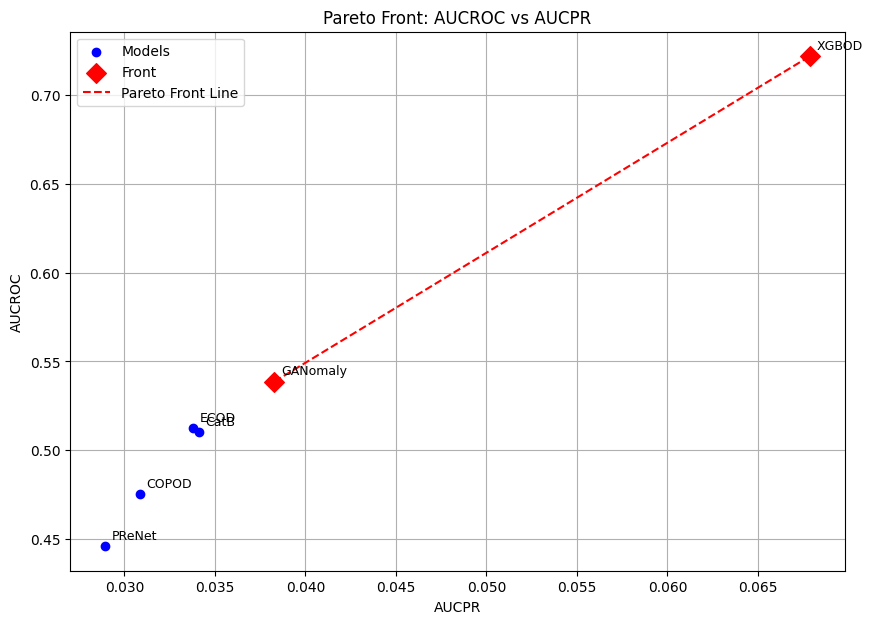

In [7]:
%matplotlib inline
# Plot the Pareto fronts, specifying the fronts to plot

pareto.plot_pareto_fronts(labels=['AUCPR', 'AUCROC'], title="Pareto Front: AUCROC vs AUCPR",
                          annotate=True, fronts_to_plot=[0, 1])


In [8]:
#  Ensemble learning
from sklearn.model_selection import train_test_split

# Concatenation of existing training and test data
X = np.concatenate((data['X_train'], data['X_test']))
y = np.concatenate((data['y_train'], data['y_test']))

# training, validation and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=seed)

print(f"Taille de X_train: {X_train.shape}")
print(f"Taille de X_val: {X_val.shape}")
print(f"Taille de X_test: {X_test.shape}")

Taille de X_train: (6000, 27)
Taille de X_val: (2000, 27)
Taille de X_test: (2000, 27)


In [9]:
model_names = top2_models_df['Model'].tolist()[:2]  # Sélectionne les deux premiers sur le front de pareto aucroc vs execution_time

# Initialization of basic models
models = {}
for name in model_names:
    clf_class = model_dict[name]
    clf = clf_class(seed=seed, model_name=name)
    clf.fit(X_train, y_train)
    models[name] = clf

best param: None


In [10]:
val_preds = pd.DataFrame()
for name, model in models.items():
    scores = model.predict_score(X_val)
    val_preds[name] = scores

In [11]:
from sklearn.linear_model import LogisticRegression

# Training of the meta-model
meta_model = LogisticRegression(random_state=seed)
meta_model.fit(val_preds, y_val)

LogisticRegression(random_state=42)

In [12]:
# Basic model predictions on the test set
test_preds = pd.DataFrame()
for name, model in models.items():
    scores = model.predict_score(X_test)
    test_preds[name] = scores

# Final predictions of the meta-model
final_scores = meta_model.predict_proba(test_preds)[:, 1]

# performance evaluation
result = utils.metric(y_true=y_test, y_score=final_scores)

new_row = pd.DataFrame({
            'Model': ['Stacked Model'],
            'AUCROC': [result['aucroc']],
            'AUCPR': [result['aucpr']]
        })
df_results = pd.concat([df_results, new_row], ignore_index=True)

print("Performance of the stacked model :")
print(f"AUCROC: {result['aucroc']}")
print(f"AUCPR: {result['aucpr']}")

Performance of the stacked model :
AUCROC: 0.7245538149793469
AUCPR: 0.05021967703756115


In [13]:
# Comparison between the meta-model and individual models
df_results = df_results.sort_values(by='AUCROC', ascending=False).reset_index(drop=True)

df_results

Model    AUCROC     AUCPR
0  Stacked Model  0.724554  0.050220
1          XGBOD  0.721894  0.067865
2       GANomaly  0.538605  0.038286
3           ECOD  0.512396  0.033768
4           CatB  0.510126  0.034110
5          COPOD  0.475179  0.030852
6         PReNet  0.445911  0.028944

In [14]:

# def is_pareto_efficient(costs):
#     """
#     Identify Pareto-efficient points.
#     Args:
#         costs (ndarray): Array of shape (n_points, n_costs) where each row is a point.
#     Returns:
#         mask (ndarray): Boolean array indicating whether each point is Pareto-efficient.
#     """
#     is_efficient = np.ones(costs.shape[0], dtype=bool)
#     for i, c in enumerate(costs):
#         if is_efficient[i]:
#             is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
#             is_efficient[i] = True
#     return is_efficient

In [15]:
# # Transformation: maximize AUCROC (we convert it to a minimization problem by taking its negative) and minimize Execution_Time.
# costs = np.column_stack([-df_results['AUCROC'].values, -df_results['AUCPR'].values])
# pareto_mask = is_pareto_efficient(costs)
# pareto_front = df_results[pareto_mask].copy()

# pareto_df = df_results[pareto_mask]

# print("Pareto Front Models:")
# print(pareto_front)


In [16]:
# # Sort Pareto front: first by AUCROC (descending) then by Execution_Time (ascending)
# pareto_front_sorted = pareto_front.sort_values(by=['AUCROC', 'AUCPR'], ascending=[False, True])

# # Select the top 2 models from the Pareto front
# top2_models_df = pareto_front_sorted.head(2).reset_index(drop=True)

# print("Top 2 Pareto Front Models:")
# print(top2_models_df)


In [17]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.figure(figsize=(8,6))
# plt.scatter(df_results['AUCPR'], df_results['AUCROC'], color='blue', label='Models')
# plt.scatter(pareto_df['AUCPR'], pareto_df['AUCROC'], color='red', marker='D', s=100, label='Pareto Front')

# # Plot the connecting line for the Pareto front
# pareto_df_sorted = pareto_df.sort_values(by='AUCPR')
# plt.plot(pareto_df_sorted['AUCPR'], pareto_df_sorted['AUCROC'], color='red', linestyle='--', label='Pareto Line')

# # Annotate each point with the model name
# for idx, row in df_results.iterrows():
#     plt.annotate(row['Model'], (row['AUCPR'], row['AUCROC']),
#                  textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

# plt.xlabel("AUCPR")
# plt.ylabel("AUCROC")
# plt.title("Pareto Front: AUCROC vs AUCPR")
# plt.legend()
# plt.grid(True)
# plt.show()